<h1>computational graphs</h1>

In [259]:
from casadi import *

In [218]:
x = MX.sym('x',2); # states
u = MX.sym('u'); #controls

# van der pol oscillator system (nonlinear ODE)
ode = vertcat((1 - x[1]**2)*x[0] - x[1] + u, x[0])

In [219]:
f = Function('f',[x,u],[ode])

In [221]:
f([0.2,0.8],0.1)

DM([-0.628, 0.2])

<h1>time integration method</h1>

In [231]:
T = 10 # time horizon
N = 20 # number of control intervals

In [237]:
# integrator to discretize the system
dae = {'x':x, 'p':u, 'ode':f(x,u)}
intg = integrator('intg', 'rk', dae, {'tf':T/N, 'number_of_finite_elements':4, 'simplify':True})

In [240]:
res = intg(x0=x,p=u) #evaluate with symbols
x_next = res['xf'] 

In [241]:
# Simplify API to (x,u)->(x_next)
F = Function('F',[x,u],[x_next])

In [245]:
F([0,1],0), F([0.1,0.9],0.1)

(DM([-0.494017, 0.876098]), DM([-0.307745, 0.849043]))

In [273]:
sim = F.mapaccum(N)

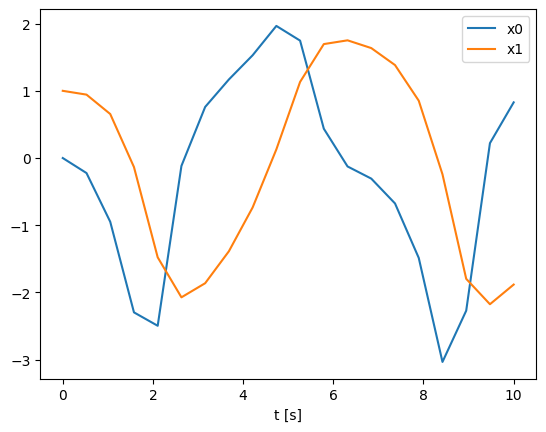

In [311]:
import matplotlib.pyplot as plt
res = sim(x0,cos(range(0,N)))
t = np.linspace(0, T, N)

# Create a figure and plot the data
plt.figure()
plt.plot(t, res.toarray().T)
plt.legend(['x0', 'x1'])
plt.xlabel('t [s]')
plt.show()